In [1]:
%load_ext autoreload

import os, sys
import networkx as nx

sys.path.insert(0, "../")

%autoreload 2
from mikg.kgraph import KGraph
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

import random
random.seed(42)

import pickle

In [2]:
#kg = KGraph()

In [3]:
#kg.load_kgraph_base("../data/", go=True, omnipath=True, opentargets=True, reactome=True, STRING=True)

In [4]:
#kg.print_kg_info()

In [5]:
#print(kg.kg)

In [6]:
#kg.save_kgraph("../data/initial_base_graph.out")

In [7]:
kg = KGraph()
kg.load_kgraph("../data/initial_base_graph.out")

In [8]:
exprDF = pd.read_csv("../seq_data/expression_mean_df.tsv", sep="\t")
cmDF = exprDF[exprDF.group == "Cardiomyocyte"]
cmDF

,group,gene,min,percentile_25,median,percentile_75,max,mean,num,sd,group_cells,perc_expr
22891,Cardiomyocyte,A1BG,0.218642,0.439190,0.607427,0.831411,2.456248,0.709995,351,0.395967,64510,0.005441
22892,Cardiomyocyte,A1BG-AS1,0.214143,0.456117,0.643483,0.936906,3.038826,0.806031,461,0.518502,64510,0.007146
22893,Cardiomyocyte,A1CF,0.208636,0.422485,0.557386,0.773439,3.025672,0.637636,706,0.321588,64510,0.010944
22894,Cardiomyocyte,A2M,0.181245,0.651118,0.944811,1.398837,3.792171,1.075190,32973,0.547520,64510,0.511130
22895,Cardiomyocyte,A2M-AS1,0.185317,0.412732,0.539294,0.709554,2.699968,0.602207,3160,0.286947,64510,0.048985
...,...,...,...,...,...,...,...,...,...,...,...,...
50958,Cardiomyocyte,ZXDC,0.185317,0.610198,0.829333,1.097115,3.521134,0.891553,35191,0.378761,64510,0.545512
50959,Cardiomyocyte,ZYG11A,0.224826,0.414667,0.540848,0.712375,2.653949,0.637458,303,0.367307,64510,0.004697
50960,Cardiomyocyte,ZYG11B,0.187795,0.600248,0.812252,1.080384,3.494183,0.880513,33025,0.386580,64510,0.511936
50961,Cardiomyocyte,ZYX,0.193169,0.445595,0.595571,0.835346,3.001737,0.705213,5338,0.395080,64510,0.082747


In [9]:
fibDF = exprDF[exprDF.group == "Fibroblast"]
fibDF

,group,gene,min,percentile_25,median,percentile_75,max,mean,num,sd,group_cells,perc_expr
102873,Fibroblast,A1BG,0.501998,1.235752,1.491982,1.768195,3.631375,1.531841,424,0.470582,47309,0.008962
102874,Fibroblast,A1BG-AS1,0.364096,1.273964,1.557159,1.973099,3.494957,1.646681,740,0.546756,47309,0.015642
102875,Fibroblast,A1CF,0.936434,1.459199,1.669136,1.904395,2.955688,1.831157,26,0.580027,47309,0.000550
102876,Fibroblast,A2M,0.247064,1.381439,1.648303,1.966196,3.730105,1.697126,7728,0.459571,47309,0.163352
102877,Fibroblast,A2M-AS1,0.505575,1.179612,1.453647,1.743054,2.720268,1.469821,283,0.438858,47309,0.005982
...,...,...,...,...,...,...,...,...,...,...,...,...
130942,Fibroblast,ZXDC,0.387950,1.322788,1.577880,1.881845,3.752063,1.619841,8704,0.436627,47309,0.183982
130943,Fibroblast,ZYG11A,0.500970,1.192219,1.493319,1.868409,3.407745,1.553399,243,0.492998,47309,0.005136
130944,Fibroblast,ZYG11B,0.361290,1.331387,1.584627,1.906673,3.565702,1.633891,8709,0.446266,47309,0.184088
130945,Fibroblast,ZYX,0.364096,1.292344,1.547185,1.865861,3.436410,1.594237,3505,0.446001,47309,0.074087


In [10]:
exprDFs = {}

for group in exprDF.group.unique():
    exprDFs[group] = exprDF[exprDF.group == group].copy()

print([x for x in exprDFs])

['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'vSMCs']


In [11]:
kg.add_gene_expression(cmDF)

28072
Found Genes 22753


In [12]:
kg.get_node_data("CCL2")

{'type': 'gene',
 'score': 0,
 'expression': {'score': 0.045441425561097454,
  'mean': 0.7961505602787607,
  'perc_expr': 0.0570764222601147,
  'median': 0.6903093253438801}}

In [13]:
kg.get_node_data("EFO:0004775")

{'type': 'disease',
 'name': 'toxic epidermal necrolysis',
 'source': 'opentargets'}

In [14]:
kg.get_node_types()

Counter({'gene': 51578, 'geneset': 49332, 'disease': 12701, 'drug': 3212})

In [15]:
kg.get_edge_types()

Counter({'activates': 113800,
         'relevant_in': 203769,
         'interacts': 2856008,
         'part_of': 200831,
         'represses': 8381,
         'affects': 35862,
         'targeted_by': 8268})

In [16]:
kg.get_edge_between_type()

Counter({('gene', 'geneset'): 412777,
         ('gene', 'gene'): 362249,
         ('geneset', 'geneset'): 74934,
         ('geneset', 'gene'): 4072,
         ('disease', 'gene'): 2528757,
         ('drug', 'disease'): 35826,
         ('drug', 'gene'): 8268,
         ('drug', 'geneset'): 36})

In [17]:
def scoring_represses(x, y):
    return x - y

def scoring_activates(x, y):
    return x*y

def scoring_interacts(x,y):
    return x*y

def scoring_null(x,y):
    return 0

scoring_gene_gene_expression = {"represses": scoring_represses, "activates": scoring_activates, "interacts": scoring_interacts, "-": scoring_null}

def gene_geneset(kg, node, edges):
    
    allExpr = list()
    for edge in edges:
        
        otherEnd = edge[0] if node==edge[1] else edge[1]
        otherExpr = kg.nodes[otherEnd].get("expression", {}).get("score", 0)
        
        allExpr.append(otherExpr)
    
    return np.mean(allExpr)
        
        

def geneset_geneset(kg, node, edges):
    
    allExpr = list()
    for edge in edges:
        
        otherEnd = edge[0] if node==edge[1] else edge[1]
        otherExpr = kg.nodes[otherEnd].get("score", 0)
        
        allExpr.append(otherExpr)
    
    return np.mean(allExpr)


def scoring_represses(x, y):
    return x - y

def scoring_activates(x, y):
    return x*y

def scoring_interacts(x,y):
    return x*y

def scoring_null(x,y):
    return 0

scoring_interactions = {"relevant_in": scoring_interacts,
                        "activates": scoring_activates,
                        "part_of": scoring_interacts,
                        "represses": scoring_represses,
                        "interacts": scoring_interacts,
                        "targeted_by": scoring_interacts,
                        "affects": scoring_interacts,
                        "-": scoring_null
                        }

def get_score(x):
    if x.get("type", "-") == "gene":
        return x.get("expression", {}).get("score", 0)
    else:
        return x.get("score", 0)

In [26]:
kg.score_gene_gene_edges(scoring_gene_gene_expression)

kg.score_nodes(ntype="geneset", consider_edge_type=[("gene", "geneset")], scoring_function=gene_geneset)
kg.score_nodes(ntype="disease", consider_edge_type=[("disease", "gene")], scoring_function=gene_geneset)
kg.score_nodes(ntype="drug", consider_edge_type=[("drug", "gene")], scoring_function=gene_geneset)

kg.score_nodes(ntype="geneset", consider_edge_type=[("geneset", "geneset")], scoring_function=geneset_geneset)
kg.score_nodes(ntype="drug", consider_edge_type=[("drug", "disease")], scoring_function=geneset_geneset)

kg.score_edges(get_score, "type", scoring_interactions, in_types=None, out_types=None, ignore_edge_types=[("gene", "gene")])


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


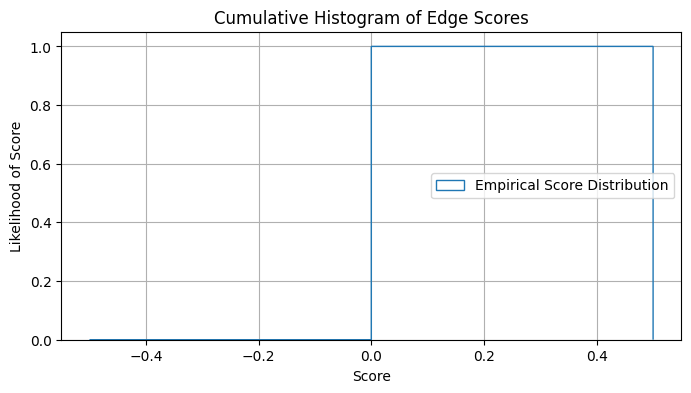

In [19]:
kg.plot_score_histogram(edge_types=[("drug", "gene")])

In [20]:
exprKGs = {}

for group in exprDFs:
    
    print(group)
    
    gKG = KGraph()
    
    gKG.load_kgraph("../data/initial_base_graph.out")

    gKG.add_gene_expression(exprDFs[group])

    gKG.score_gene_gene_edges(scoring_gene_gene_expression)

    gKG.score_nodes(ntype="geneset", consider_edge_type=[("gene", "geneset")], scoring_function=gene_geneset)
    gKG.score_nodes(ntype="disease", consider_edge_type=[("disease", "gene")], scoring_function=gene_geneset)
    gKG.score_nodes(ntype="drug", consider_edge_type=[("drug", "gene")], scoring_function=gene_geneset)

    gKG.score_nodes(ntype="geneset", consider_edge_type=[("geneset", "geneset")], scoring_function=geneset_geneset)
    gKG.score_nodes(ntype="drug", consider_edge_type=[("drug", "disease")], scoring_function=geneset_geneset)
    
    gKG.score_edges(get_score, "type", scoring_interactions, in_types=None, out_types=None, ignore_edge_types=[("gene", "gene")])
        
    exprKGs[group] = gKG

Adipocyte
22891
Found Genes 19560


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cardiomyocyte
28072
Found Genes 22753
Cycling cells
24070
Found Genes 20461
Endothelial
27840
Found Genes 22680
Fibroblast
28074
Found Genes 22822
Lymphoid
25525
Found Genes 21392
Mast
20817
Found Genes 18299
Myeloid
27246
Found Genes 22374
Neuronal
24790
Found Genes 20837
Pericyte
26333
Found Genes 21782
vSMCs
24144
Found Genes 20401


In [21]:
import pickle

with open("exprkgs.pickle", 'wb') as f:
    pickle.dump(exprKGs, f)

In [22]:
for edge in kg.get_node_edges("CCL2", in_types=["gene"], out_types=["gene"]):
    
    inExpr = kg.get_node_data(edge[0]).get("expression", {}).get("mean", 0)
    outExpr = kg.get_node_data(edge[1]).get("expression", {}).get("mean", 0)
    edgeType = kg.kg.edges[edge].get("type", "-")
    
    print(edge, edgeType, kg.kg.edges[edge]["score"])

('NFE2L2', 'CCL2') represses 0.41951645583441255
('CCL13', 'CCL2') interacts 2.813928229373769e-05
('JUN', 'CCL2') interacts 0.013438076371693454
('FOSL1', 'CCL2') activates 0.0005785075927194532
('LIF', 'CCL2') interacts 0.00012735818074583632
('TNF', 'CCL2') interacts 1.700198920569425e-05
('TNFSF11', 'CCL2') activates 9.677589249760668e-06
('CSF2', 'CCL2') interacts 0.0
('CSF1', 'CCL2') interacts 0.0010823871260703226
('JAK2', 'CCL2') activates 0.02545820238419906
('OLR1', 'CCL2') activates 4.670583917795123e-05
('FOS', 'CCL2') interacts 0.006141870824852591
('HMOX1', 'CCL2') represses -0.03035098396655416
('CDK9', 'CCL2') activates 0.002584812054108121
('IL18', 'CCL2') interacts 0.0018557726910590848
('IL32', 'CCL2') activates 0.0009116643689669329
('ESR2', 'CCL2') represses 0.2042281240984477
('OSM', 'CCL2') activates 1.9698065359313038e-05
('IL6', 'CCL2') interacts 0.0001198742857430992
('SAA1', 'CCL2') activates 6.392819618803187e-05
('FPR1', 'CCL2') activates 0.0002613918347348

In [27]:
for edge in kg.get_node_edges("CCL2"):

    edgeType = kg.kg.edges[edge].get("type", "-")
    
    print(edge, kg.kg.edges[edge])
    print(edge, edgeType, kg.kg.edges[edge]["score"])

('NFE2L2', 'CCL2') {'type': 'represses', 'source': 'omnipath', 'omnipath_evidences': ['NRF2ome:16246346'], 'omnipath_type': 'post_translational', 'score': 0.41951645583441255}
('NFE2L2', 'CCL2') represses 0.41951645583441255
('CCL13', 'CCL2') {'type': 'interacts', 'source': 'STRING', 'omnipath_evidences': ['InnateDB:16803905'], 'omnipath_type': 'post_translational', 'string_scores': {'fusion': 0, 'coexpression': 138, 'experiments': 237, 'database': 0, 'textmining': 830, 'score': 0.83}, 'score': 2.813928229373769e-05}
('CCL13', 'CCL2') interacts 2.813928229373769e-05
('JUN', 'CCL2') {'type': 'interacts', 'source': 'STRING', 'omnipath_evidences': ['nan'], 'omnipath_type': 'transcriptional', 'string_scores': {'fusion': 0, 'coexpression': 0, 'experiments': 0, 'database': 900, 'textmining': 681, 'score': 0.9}, 'score': 0.013438076371693454}
('JUN', 'CCL2') interacts 0.013438076371693454
('FOSL1', 'CCL2') {'type': 'activates', 'source': 'omnipath', 'omnipath_evidences': ['nan'], 'omnipath_ty

In [28]:
kg.kg.nodes["GO:0007568"]

{'id': 'GO:0007568',
 'name': 'aging',
 'type': 'geneset',
 'ns': 'biological_process',
 'score': 0.11784663351640698,
 'source': 'GeneOntology'}

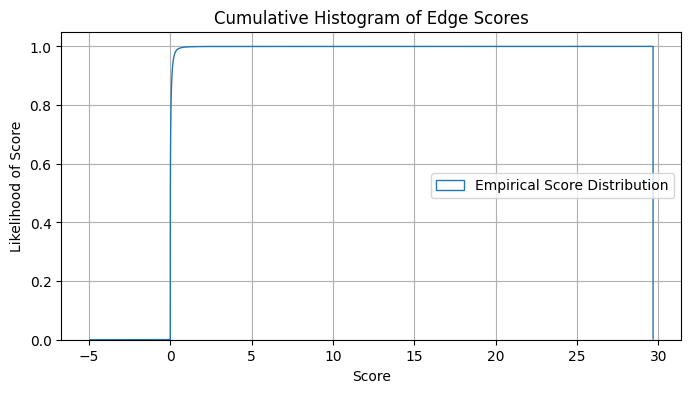

In [29]:
kg.plot_score_histogram()

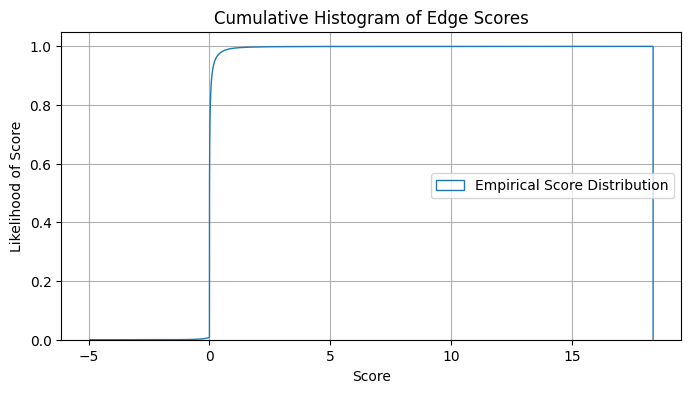

In [30]:
kg.plot_score_histogram(edge_types=[("gene", "gene")])

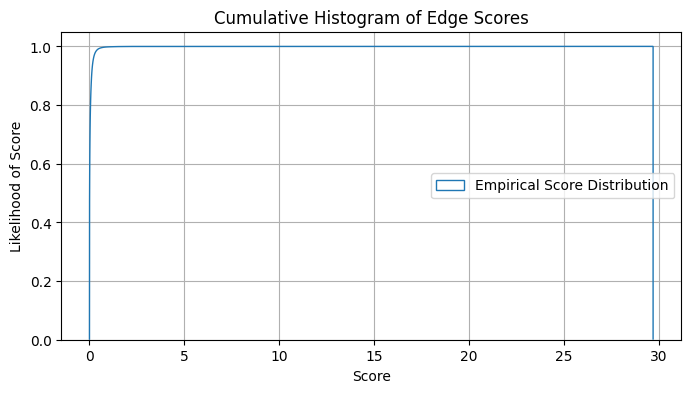

In [31]:
kg.plot_score_histogram(edge_types=[("disease", "gene")])

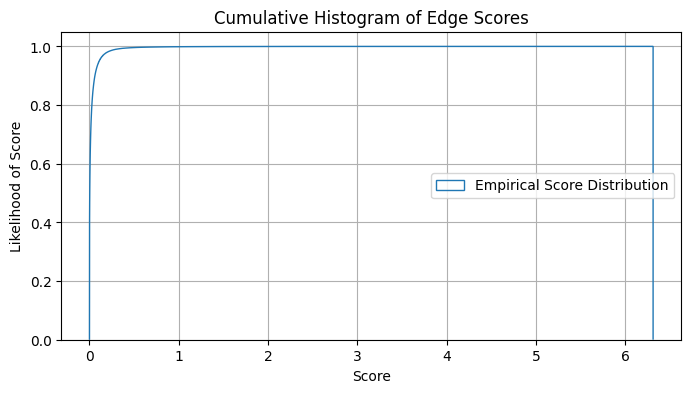

In [32]:
kg.plot_score_histogram(edge_types=[("gene", "geneset")])

['gene -> geneset', 'gene -> gene', 'geneset -> geneset', 'geneset -> gene', 'disease -> gene', 'drug -> disease', 'drug -> gene', 'drug -> geneset']
             class  value
0  gene -> geneset    0.0
1  gene -> geneset    0.0
2  gene -> geneset    0.0
3  gene -> geneset    0.0
4  gene -> geneset    0.0


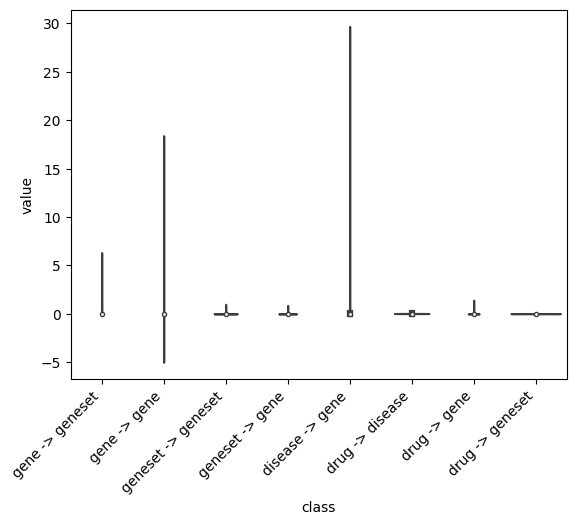

In [33]:
kg.plot_score_violin(per_edge_type=True)

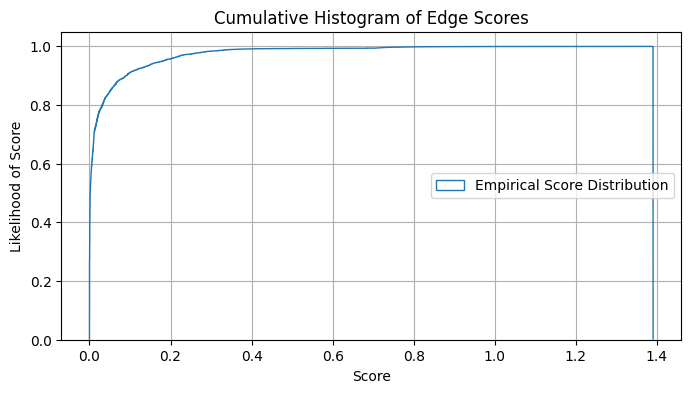

In [34]:
kg.plot_score_histogram(edge_types=[("drug", "gene")])

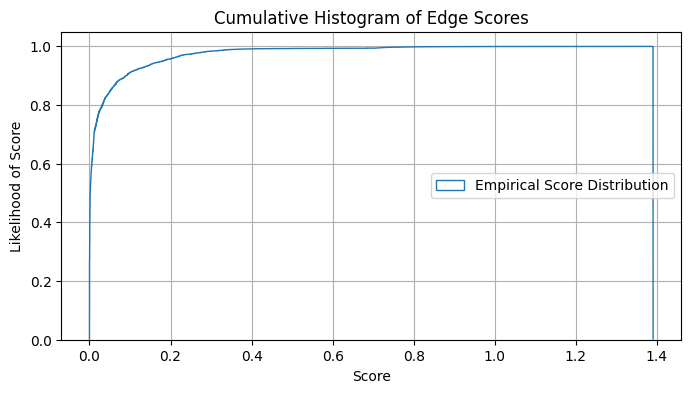

In [35]:
exprKGs["Cardiomyocyte"].plot_score_histogram(edge_types=[("drug", "gene")])

In [36]:
#exprKGs = pickle.load(open("exprkgs.pickle", "rb"))

In [ ]:
kg=exprKGs["Cardiomyocyte"]

In [37]:
kg.random_state=42

In [57]:
comms = kg.get_communities(minEdgeScore = 1.0, resolution=4)

DiGraph with 2687 nodes and 6694 edges


In [59]:
sigcomm = kg.identify_differential_communities(comms, exprKGs)

community Module 0 30
Adipocyte {'median_other': 0.5215180576011162, 'median_own': 1.2617487842999786, 'logFC': -1.2746355844500836, 'ks': KstestResult(statistic=0.6818181818181818, pvalue=6.579514364791611e-15)}
Cardiomyocyte {'median_other': 1.2617487842999786, 'median_own': 1.2617487842999786, 'logFC': 0.0, 'ks': KstestResult(statistic=0.0, pvalue=1.0)}
Cycling cells {'median_other': 0.2500014931638469, 'median_own': 1.2617487842999786, 'logFC': -2.3354160798999666, 'ks': KstestResult(statistic=0.7727272727272727, pvalue=1.141550506585959e-19)}
Endothelial {'median_other': 0.28782493663677333, 'median_own': 1.2617487842999786, 'logFC': -2.132161201475557, 'ks': KstestResult(statistic=0.7575757575757576, pvalue=8.347588079409825e-19)}
Fibroblast {'median_other': 0.2768460126219621, 'median_own': 1.2617487842999786, 'logFC': -2.188269048417815, 'ks': KstestResult(statistic=0.696969696969697, pvalue=1.2336589433984272e-15)}
Lymphoid {'median_other': 0.28161804814382707, 'median_own': 1

In [60]:
sigcomm

['Module 0',
 'Module 1',
 'Module 2',
 'Module 3',
 'Module 5',
 'Module 6',
 'Module 9',
 'Module 66',
 'Module 12',
 'Module 14',
 'Module 15',
 'Module 16',
 'Module 17',
 'Module 18',
 'Module 19',
 'Module 98',
 'Module 22',
 'Module 24',
 'Module 25',
 'Module 26',
 'Module 59',
 'Module 28',
 'Module 29',
 'Module 30',
 'Module 31',
 'Module 32',
 'Module 79',
 'Module 34',
 'Module 35',
 'Module 37',
 'Module 38',
 'Module 39',
 'Module 40',
 'Module 41',
 'Module 42',
 'Module 44',
 'Module 46',
 'Module 47',
 'Module 48',
 'Module 49',
 'Module 50',
 'Module 51',
 'Module 52',
 'Module 53',
 'Module 56',
 'Module 57',
 'Module 58',
 'Module 60',
 'Module 61',
 'Module 62',
 'Module 65',
 'Module 67',
 'Module 75',
 'Module 80']

Module 0


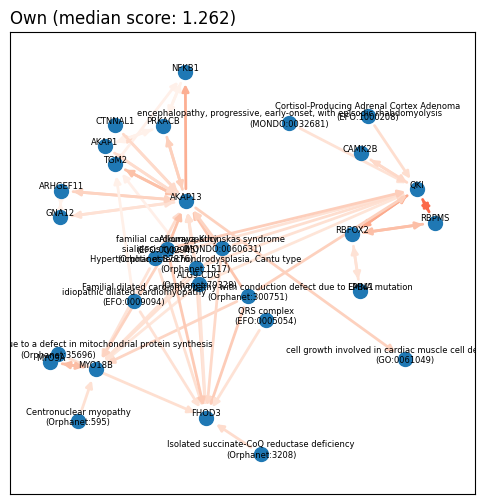

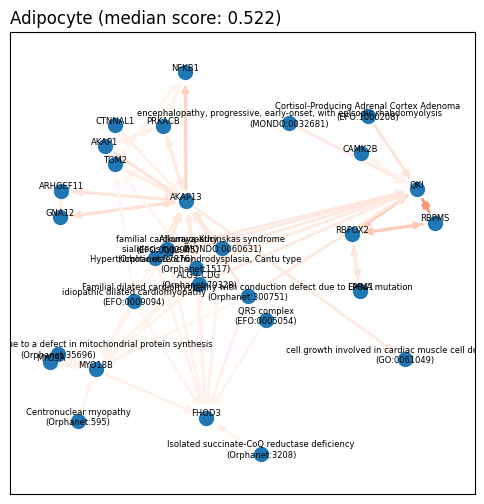

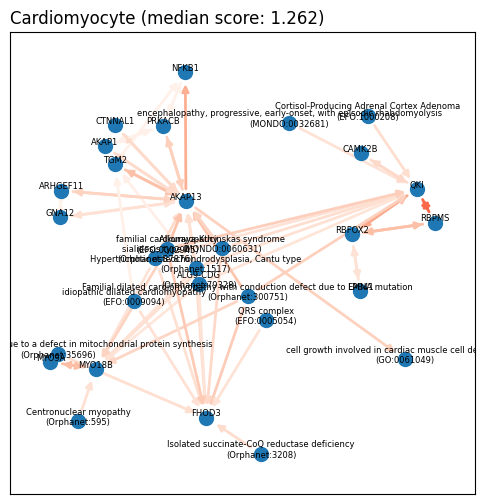

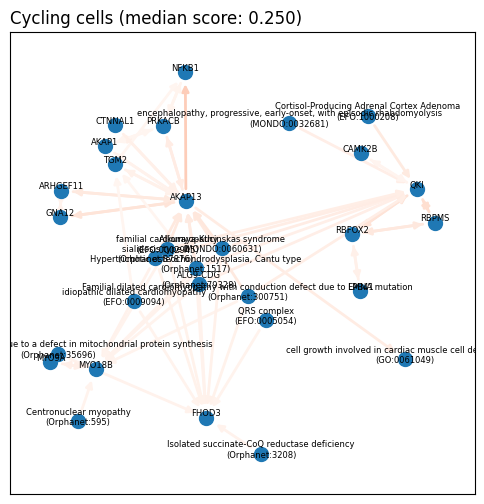

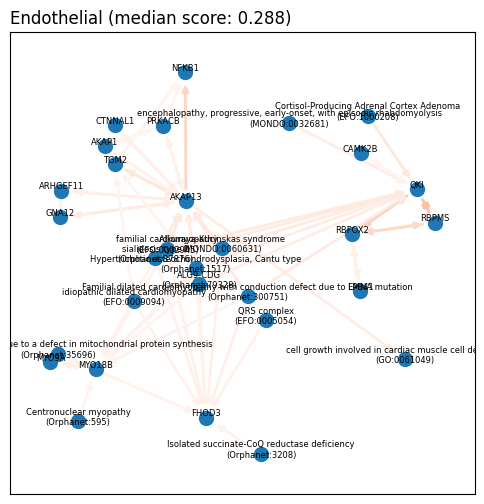

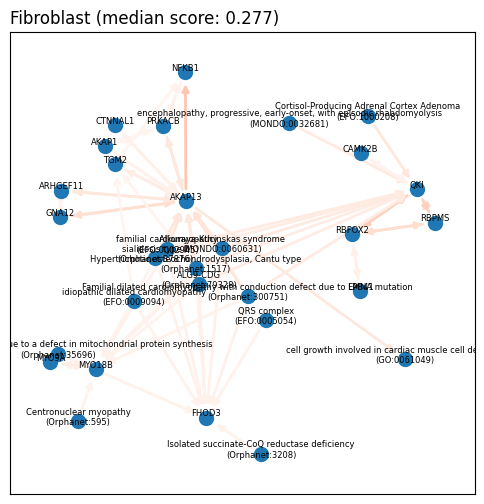

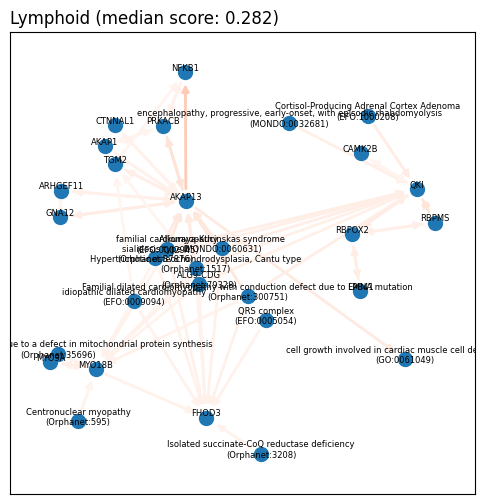

In [66]:
matplotlib.rcParams['figure.figsize'] = [6, 6]


for comm in comms:
    
    if 10 < len(comms[comm]) < 100:
        
        print(comm)
        kg.plot_communities(exprKGs, [comms[comm]], font_size=6)

In [ ]:
#exprKGs = pickle.load(open("exprkgs.pickle", "rb"))

0 540
1 274
2 40
3 49
4 143
5 70
6 108
7 128
8 236
9 160
11 37
12 181
37 61
16 38
18 30
19 33
14 25
22 23